<a href="https://colab.research.google.com/github/Harshp1802/Neural-Style-Transfer/blob/master/Style_Transfer_Harsh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import functools
from tensorflow.keras.applications import vgg19
from tensorflow.python.keras.preprocessing import image as kp_image

In [0]:
content_path = '/content/lal_minar.jpg'
style_path = '/content/style.jpg'

In [0]:
#defined functions for loading and showing the images:
def load_img(path):
  max_dim = 512
  img = Image.open(path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  return img
def imshow(img, title=None):
  #out = np.squeeze(img, axis=0)
  img = img.astype('uint8')
  plt.imshow(img)
  if title is not None:
    plt.title(title)
  plt.imshow(img)

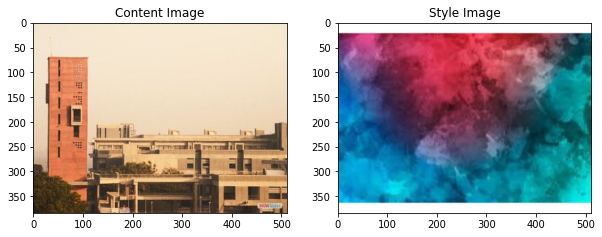

In [0]:
plt.figure(figsize=(10,10))
content_image = load_img(content_path).astype('uint8')
style_image = load_img(style_path).astype('uint8')
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.show()

In [0]:
#Using a popular pre-trained CNN Model having 16 convolutional layers.
model = vgg19.VGG19(include_top=False,weights="imagenet")
model.summary()

In [0]:
# This are the layers of the above CNN model from which we get the content and the output layers.
Content_layers = ["block5_conv1"]
Style_layers = ["block4_conv1","block4_conv2","block4_conv3","block4_conv4"]

In [0]:
#Calling the model using the keras API
def call_model():   
    model = vgg19.VGG19(include_top=False,weights="imagenet")
    model.trainable= False
    content_layers = Content_layers
    style_layers = Style_layers
    output_layers = [model.get_layer(layer).output for layer in (content_layers+style_layers)]
    return tf.keras.models.Model(model.input,output_layers)
model = call_model()

In [0]:
# The inputs to this VGG19 Network are required to be processed before using the model.
processed_content_img = vgg19.preprocess_input(np.expand_dims(content_image,axis=0))
processed_style_img = vgg19.preprocess_input(np.expand_dims(style_image,axis=0))

In [0]:
#Getting the output(required layers) from the model:
model_output_content = model(processed_content_img)
model_output_style = model(processed_style_img)

In [0]:
def get_content_loss(new_image_content,base_image_content):
    return np.mean(np.square(new_image_content-base_image_content))

In [0]:
#Gram Matrix: Corelation matrix between the filters of the image.
def get_gram_matrix(output):
    style_layer = output
    A = tf.reshape(style_layer,(-1,style_layer.shape[-1])) 
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a=True)
    n=gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n

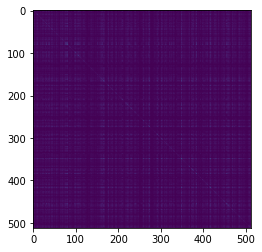

In [0]:
gram_matrix,N = get_gram_matrix(model_output_style[2])
plt.figure(figsize=(4,4))
plt.imshow(gram_matrix.numpy());

In [0]:
def get_style_loss(new_image_style,base_style):
    new_style_gram,gram_num_height = get_gram_matrix(new_image_style)
    base_style_gram,gram_num_height2 = get_gram_matrix(base_style)
    assert gram_num_height == gram_num_height2
    gram_num_filters = new_style_gram.shape[0]
    loss = tf.reduce_sum(tf.square(base_style_gram - new_style_gram)/(4*(gram_num_height**2)*(gram_num_filters**2)))
    return loss

In [0]:
def get_total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.95):
    new_image_styles = new_image_output[len(Content_layers):]
    base_image_styles = base_style_image_output[len(Content_layers):]
    style_loss=0
    N = len(new_image_styles)
    for i in range(N):
        style_loss+=get_style_loss(new_image_styles[i],base_image_styles[i])
    
    new_image_contents = new_image_output[:len(Content_layers)]
    base_image_contents = base_content_image_output[:len(Content_layers)]
    content_loss = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss+=get_content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*style_loss+alpha*content_loss

In [0]:
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))
def deprocess(processed_img):
    unprocessed_img = processed_img-VGG_BIASES
    unprocessed_img = tf.unstack(unprocessed_img,axis=-1)
    unprocessed_img = tf.stack([unprocessed_img[2],unprocessed_img[1],unprocessed_img[0]],axis=-1)
    return unprocessed_img

In [0]:
base_style_outputs = model(processed_style_img)
#plt.imshow(deprocess(processed_style_img)[0]/255)
base_content_output = model(processed_content_img)
plt.imshow(deprocess(processed_content_img)[0]/255)

In [0]:
processed_content_var = tf.Variable(processed_content_img)
optimizer = tf.optimizers.Adam(5,beta_1=.99,epsilon=1e-3)
from IPython.display import display,clear_output
i=0
best_loss = 180000
min_vals = VGG_BIASES
max_vals = 255+VGG_BIASES
for i in range(400):   
    with tf.GradientTape() as tape:
        tape.watch(processed_content_var)
        content_var_outputs = model(processed_content_var)
        loss = get_total_loss(content_var_outputs,base_content_output,base_style_outputs,alpha=.97)
        grad = tape.gradient(loss,processed_content_var)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)
        if loss<best_loss:
            best_image = processed_content_var
            best_loss=loss
        display(loss)
        clear_output(wait=True)

<tf.Tensor: shape=(), dtype=float32, numpy=11820.203>

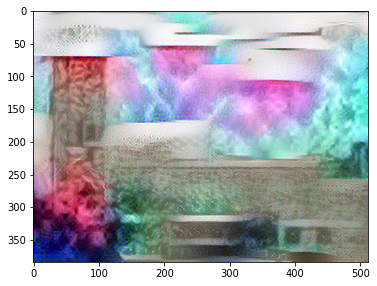

In [0]:
deprocessed_best_image = deprocess(best_image)
plt.figure(figsize=(6,6))
plt.imshow(deprocessed_best_image[0]/255)